In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.colors as plc 
import xclim.indices as xc
from xclim.indices import warm_and_dry_days
from xclim.indices import warm_and_wet_days
from xclim.core.calendar import percentile_doy
#import pymannkendall as mk
import geopandas as gpd

from xclim.core.units import (
    convert_units_to,
    declare_units,
    ensure_delta,
    pint2cfunits,
    rate2amount,
    str2pint,
    to_agg_units,
)
from xclim.core.calendar import resample_doy
import colormap as zcol

## Colorbar

In [2]:
!pip install lxml

In [3]:
import sys
sys.path.insert(0,'/home/jovyan/pilot2/zapata/')
import mycolormap as zcol
ss = zcol.make_cmap('3w_bgYr', colpath ='/home/jovyan/pilot2/zapata/SciVis_colormaps/')

Using colormap /home/jovyan/pilot2/zapata/SciVis_colormaps//3w_bgYr.xml


## Path

In [4]:
path= '/home/jovyan/pilot2/data/Vhr-rea_It'
path_perc='/home/jovyan/pilot2/data/Percentile'
path_nc= '/home/jovyan/pilot2/Output/netcdf'
path_csv= '/home/jovyan/pilot2/Output/csv'
path_shape= '/home/jovyan/pilot2/Output/shape'
path_mask= '/home/jovyan/pilot2/mask_Torino'
path_map= '/home/jovyan/pilot2/Output/map'

## Summer Days= Number of days with daily maximum temperature greater than 25°C. 

In [4]:
##DATA
#Loading data: Max. Temperature
data_temp= xr.open_dataset(path+'/TMAX_2M_1991_2020_VHR-REA_IT_comune_torino.nc') 
tasmax=data_temp['TMAX_2M']
tasmax.attrs["units"] = "K"

In [14]:
##Evaluation
Su=xc.tx_days_above(tasmax, thresh='25 degC', freq='YS')
Su_mean=Su.mean(dim='time')
Su_mean=Su_mean.to_dataset(name='Su')
Su=Su_mean.to_netcdf(path_nc+'/su_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [9]:
#CSV
Su_mean=Su.mean(dim= ['rlat','rlon']) 
Su_std=Su.std(dim= ['rlat','rlon'])
df=Su_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m']).rename(columns= {'TMAX_2M':'Su[days]'})
df_std=Su_std.to_dataframe().reset_index().drop(columns=['height_2m']).rename(columns= {'TMAX_2M':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Su[days]'] = np.round(df['Su[days]'],0)
df.to_csv(path_csv+'/su_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [ ]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Su_mean= Su.mean(dim='time')
clip_var = msk_me * Su_mean
ds=clip_var.to_dataset(name='Su[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m']).dropna().reset_index(drop=True)
df['Su[d]'] = np.round(df['Su[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/su_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/tmp/ipykernel_127/469874319.py:35: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
/tmp/ipykernel_127/469874319.py:36: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin = vmin, vmax= vmax+3)


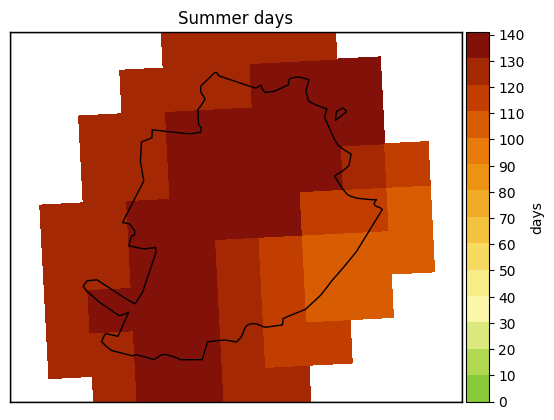

In [15]:
#Map
ds = xr.open_dataset(path_nc+'/su_era5-2km-italy_year_comune_torino_1991-2020.nc')

Su =  np.round((ds['Su']),0)
lon = ds.lon.values
lat = ds.lat.values

vmax = round(np.nanmax(Su),0)
vmin = 0

ticks = np.round(np.arange(vmin, vmax+3,10),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+3, 10),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.96, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * Su
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax+3)
cbar.set_label('days')
plt.title('Summer days')
plt.savefig(path_map+'/su_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Tropical Night= Number of days with daily minimum temperature greater than 20°C.

In [16]:
##DATA
#Loading data: Min. Temperature
data_temp= xr.open_dataset(path+'/TMIN_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tn=data_temp['TMIN_2M']
tn.attrs["units"] = "K"

In [18]:
##Evaluation
Tr= xc.tn_days_above(tn, thresh='20.0 degC', freq='YS')
Tr_mean=Tr.mean(dim='time')
Tr_mean=Tr_mean.to_dataset(name='Tr')
#Tr=Tr_mean.to_netcdf(path_nc+'/tr_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [19]:
#CSV
Tr_mean=Tr.mean(dim= ['rlat','rlon'])
Tr_std=Tr.std(dim= ['rlat','rlon'])
df=Tr_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m']).rename(columns= {'TMIN_2M':'Tr[days]'})
df_std=Tr_std.to_dataframe().reset_index().drop(columns=['height_2m']).rename(columns= {'TMIN_2M':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Tr[days]'] = np.round(df['Tr[days]'],0)
df.to_csv(path_csv+'/tr_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [20]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Tr_mean= Tr.mean(dim='time')
clip_var = msk_me * Tr_mean
ds=clip_var.to_dataset(name='Tr[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m']).dropna().reset_index(drop=True)
df['Tr[d]'] = np.round(df['Tr[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/tr_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


/tmp/ipykernel_127/273194979.py:35: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
/tmp/ipykernel_127/273194979.py:36: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin = vmin, vmax= vmax)


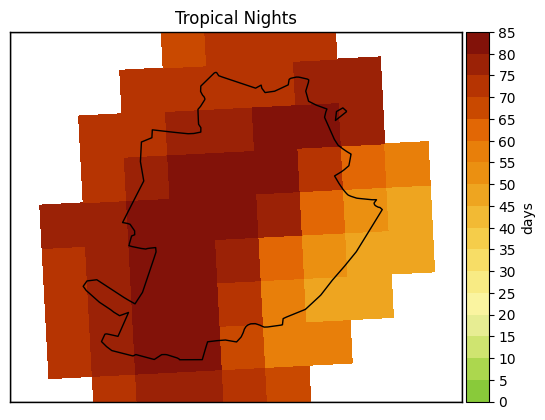

In [23]:
#Map
ds = xr.open_dataset(path_nc+'/tr_era5-2km-italy_year_comune_torino_1991-2020.nc')

Tr = np.round((ds['Tr']),0)
lon = ds.lon.values
lat = ds.lat.values

vmax = round(np.nanmax(Tr),0)
vmin = 0

ticks = np.round(np.arange(vmin, vmax+1,5),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+1, 5),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.96, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * Tr
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax)
cbar.set_label('days')
plt.title('Tropical Nights')
plt.savefig(path_map+'/tr_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Hot waves= Number of days with daily maximum temperature greater than 35°C.

In [40]:
##DATA
#Loading data: Max. Temperature
data_temp= xr.open_dataset(path+'/TMAX_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tasmax=data_temp['TMAX_2M']
tasmax.attrs["units"] = "K"

In [41]:
##Evaluation
Hw=xc.tx_days_above(tasmax, thresh='35 degC', freq='YS')
Hw_mean=Hw.mean(dim='time')
Hw_mean=Hw_mean.to_dataset(name='Hw')
#Hw=Hw_mean.to_netcdf(path_nc+'/hw_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [42]:
#CSV
Hw_mean=Hw.mean(dim= ['rlat','rlon']) 
Hw_std=Hw.std(dim= ['rlat','rlon'])
df=Hw_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m']).rename(columns= {'TMAX_2M':'Hw[days]'})
df_std=Hw_std.to_dataframe().reset_index().drop(columns=['height_2m']).rename(columns= {'TMAX_2M':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Hw[days]'] = np.round(df['Hw[days]'],0)
df.to_csv(path_csv+'/hw_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [43]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Hw_mean= Hw.mean(dim='time')
clip_var = msk_me * Hw_mean
ds=clip_var.to_dataset(name='Hw[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m']).dropna().reset_index(drop=True)
df['Hw[d]'] = np.round(df['Hw[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/hw_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


/tmp/ipykernel_127/366555250.py:33: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks, label= ticks_label)
/tmp/ipykernel_127/366555250.py:34: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin = vmin, vmax= vmax+1)


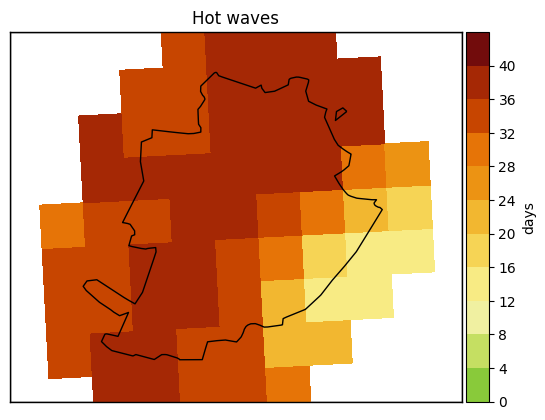

In [44]:
#Map
ds = xr.open_dataset(path_nc+'/hw_era5-2km-italy_year_comune_torino_1991-2020.nc')

Hw = np.round((ds['Hw']),0)
lon = ds.lon.values
lat = ds.lat.values

vmax = round(np.nanmax(Hw),0) 
vmin = 0

ticks = np.round(np.arange(vmin, vmax+1,4),0)
ticks_label = np.round(np.arange(vmin, vmax+1,4),0)
colors = ss(np.linspace(0.6, 0.97, len(ticks)))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * Hw
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks, label= ticks_label)
plt.clim(vmin = vmin, vmax= vmax+1)
cbar.set_label('days')
plt.title('Hot waves')
plt.savefig(path_map+'/hw_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Humidex5= It is a measure of perceived heat that results from the combined effect of humidity and temperature. Category 5: number of days per year in which the humidex index is greater than 45°C. 

In [7]:
##DATA
#Loading data: Temperature, humidity and pressure 
data_umidità_s = xr.open_dataset(path+'/QV_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
q=data_umidità_s['QV_2M']
q = q.load()
data_temp=xr.open_dataset(path+'/T_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
t=data_temp['T_2M']
t = t.load()
data_press=xr.open_dataset(path+'/PMSL_1991_2020_VHR-REA_IT_comune_torino.nc')
p=data_press['PMSL']
p = p.load()

In [8]:
#Components for the evaluation of the index
T0 = 273.15
w = q #the mixing ratio can be approximated with the specific humidity

es = 611.0 * np.exp((17.67*(t - T0)) / (t - 29.65))

w_s =0.622*(es / p)
rh = np.round((w / w_s) * 100)

rh = xr.where(rh > 100, 100, rh)
rh.attrs["units"] = "%"
rh = rh.load()

In [9]:
#Loading data: Max. temperature
data_tempmax=xr.open_dataset(path+'/TMAX_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tasmax=data_tempmax['TMAX_2M']
tasmax = tasmax.load()
tasmax_deg=tasmax-273.15
tasmax_deg = tasmax_deg.load()

In [10]:
#Evaluation
exphum=6.11*10**(7.5*tasmax_deg/(237.7+tasmax_deg))*rh.values/100;
humidex=tasmax_deg+0.5555*(exphum-10);
classe_media1=xr.where(humidex >=45,1,0)   #Category 5-number of days per year in which the humidex index is greater than 45°C.
classe_media2=classe_media1.resample(time='1Y').sum(dim='time')
classe_media3=classe_media2.mean(dim='time')
classe_media3=classe_media3.to_dataset(name='Humidex5')
#Humidex5=classe_media3.to_netcdf(path_nc+'/humidex-5_era5-2km-italy_year_comune_torino_1991-2020.nc')

/opt/conda/lib/python3.11/site-packages/xarray/groupers.py:403: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [49]:
#CSV
ds=classe_media2.to_dataset(name='Humidex5[days]')
Humidex_mean=ds.mean(dim= ['rlat','rlon'])
Humidex_std=ds.std(dim= ['rlat','rlon'])
df=Humidex_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m'])
df_std=Humidex_std.to_dataframe().reset_index().drop(columns=['height_2m']).rename(columns= {'Humidex5[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Humidex5[days]'] = np.round(df['Humidex5[days]'],0)
df.to_csv(path_csv+'/humidex-5_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [50]:
#Shapefile
mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Humidex5_mean=classe_media2.mean(dim='time')
clip_var = msk_me * Humidex5_mean
ds=clip_var.to_dataset(name='Humidex5[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m']).dropna().reset_index(drop=True)   
df['Humidex5[d]'] = np.round(df['Humidex5[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/humidex-5_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/tmp/ipykernel_127/3690293735.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(path_shape+'/humidex-5_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')
/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Humidex5[d]' to 'Humidex5[d'
  ogr_write(


/tmp/ipykernel_165/2706514508.py:42: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks_label)
/tmp/ipykernel_165/2706514508.py:43: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin=vmin, vmax=vmax+1)


Text(0.5, 1.0, 'Humidex5')

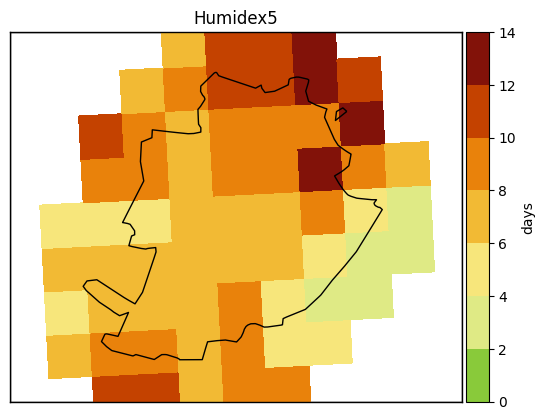

In [18]:
#Map 
Humidex5 = classe_media3 
lon = classe_media3.lon.values 
lat = classe_media3.lat.values 

# Carica la maschera
mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']
clip_var_ds = msk_me * Humidex5

# Estrai la variabile Humidex5 dal Dataset
clip_var = clip_var_ds['Humidex5']

# Calcola vmin, vmax e ticks
vmax = round(np.nanmax(clip_var), 0) 
vmin = 0
ticks = np.round(np.arange(vmin, vmax+2, 2), 1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+2, 2), 1)
ticks_label1 = np.append(ticks_label, vmax)

# Definisci colors e cmap
colors = ss(np.linspace(0.6, 0.96, len(ticks)-1))
cmap = plc.ListedColormap(colors)

# Crea la mappa
mp = Basemap(projection='merc', 
             llcrnrlon=np.nanmin(lon), 
             llcrnrlat=np.nanmin(lat), 
             urcrnrlon=np.nanmax(lon), 
             urcrnrlat=np.nanmax(lat), 
             resolution='i')
mp.drawmapboundary()
x, y = mp(lon, lat)
mp.drawcoastlines(linewidth=1)
mp.drawmapboundary()

mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)

c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:,:]), cmap=cmap)
cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks_label)
plt.clim(vmin=vmin, vmax=vmax+1)
cbar.set_label('days')
plt.title('Humidex5')
#plt.savefig(path_map+'/humidex-5_era5-2km-italy_year_comune_torino_1991-2020.png', dpi=300)

## WSDI= Total number of days per period in which the daily maximum temperature is greater than the 90th percentile of the daily maximum temperature in intervals of at least 6 consecutive days.


In [5]:
##DATA
#Loading data: Max. temperature and 90th percentile of Max. temperature
data_temp= xr.open_dataset(path+'/TMAX_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tasmax=data_temp['TMAX_2M']
tasmax.attrs["units"] = "K"
tasmax_per=xr.open_dataset(path_perc+'/90perc_tmax_2m_torino.nc')
tasmax_per=tasmax_per['Tmax_90th']
tasmax_per.attrs["units"] = "K"

In [6]:
#Evaluation
WSDI=xc.warm_spell_duration_index(tasmax, tasmax_per, window=6, freq='YS')
WSDI_mean=WSDI.mean(dim='time')
WSDI_mean=WSDI_mean.to_dataset(name='WSDI')
#WSDI=WSDI_mean.to_netcdf(path_nc+'/wsdi_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [7]:
#CSV
ds=WSDI.to_dataset(name='Wsdi[days]')
Wsdi_mean=ds.mean(dim= ['rlat','rlon']) #comando per serie storiche
Wsdi_std=ds.std(dim= ['rlat','rlon'])
df=Wsdi_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m', 'quantile']) 
df_std=Wsdi_std.to_dataframe().reset_index().drop(columns=['height_2m','quantile']).rename(columns= {'Wsdi[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Wsdi[days]'] = np.round(df['Wsdi[days]'],0)
df.to_csv(path_csv+'/wsdi_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [8]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

WSDI_mean= WSDI.mean(dim='time')
clip_var = msk_me * WSDI_mean
ds=clip_var.to_dataset(name='Wsdi[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m', 'quantile']).dropna().reset_index(drop=True)
df['Wsdi[d]'] = np.round(df['Wsdi[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/wsdi_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


/tmp/ipykernel_152/4195248493.py:35: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
/tmp/ipykernel_152/4195248493.py:36: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin = vmin, vmax= vmax)


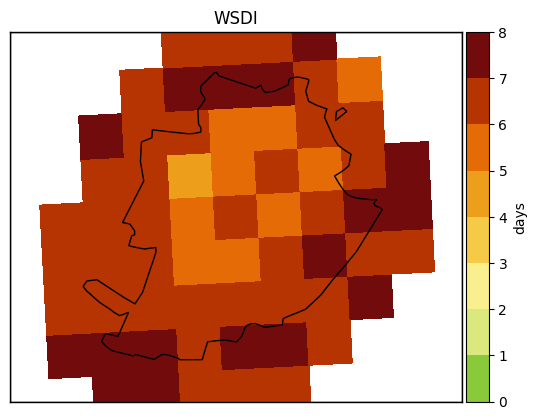

In [9]:
#Map
ds = xr.open_dataset(path_nc+'/wsdi_era5-2km-italy_year_comune_torino_1991-2020.nc')

Wsdi = ds['WSDI']
lon = ds.lon.values
lat = ds.lat.values

vmax = round(np.nanmax(Wsdi),0) 
vmin = 0

ticks = np.round(np.arange(vmin, vmax+1,1),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+1, 1),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * Wsdi
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax)
cbar.set_label('days')
plt.title('WSDI')
plt.savefig(path_map+'/wsdi_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Discomfort Index= It is a physiological thermal stress indicator for people based on dry-bulb and wet-bulb temperature.

In [22]:
##DATA
#Loading data: Max. temperature, humidity and pressure 
data_temp = xr.open_dataset(path+'/T_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
t=data_temp['T_2M'].values
data_umidità_s = xr.open_dataset(path+'/QV_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
q=data_umidità_s['QV_2M']
data_press=xr.open_dataset(path+'/PMSL_1991_2020_VHR-REA_IT_comune_torino.nc')
p=data_press['PMSL']

In [23]:
#Components for the evaluation of the index
T0 = 273.15
w = q #the mixing ratio can be approximated with the specific humidity

es = 611.0 * np.exp((17.67*(t - T0)) / (t - 29.65))

w_s =0.622*(es / p)
rh = np.round((w / w_s) * 100)

rh = xr.where(rh > 100, 100, rh)
rh.attrs["units"] = "%"
rh = rh.load()

In [25]:
##DATA
#Loading data: Max. Temperature
data_temp= xr.open_dataset(path+'/TMAX_2M_1991_2020_VHR-REA_IT_comune_torino.nc') 
tasmax=data_temp['TMAX_2M'].values

In [27]:
##Evaluation
tasmax_deg=tasmax-273.15
THI=tasmax_deg-(0.55 - 0.0055*rh) *(tasmax_deg-14.5)    #THI = Ta - (0.55 - 0.0055 * UR) (Ta - 14.5). Since it is not always possible to know the wet bulb temperature, the formula of the Thermohygrometric Index (THI) can be used
condition= (THI>=29) & (THI<32) #Threshold indicating dangerous conditions
classe=xr.where(condition,1,0)
classe_media=classe.resample(time='1Y').sum(dim='time')
classe_media1=classe_media.mean(dim='time')
classe_media2=classe_media1.to_dataset(name='Di')
Di_index=classe_media2.to_netcdf(path_nc+'/Di_era5-2km-italy_year_comune_torino_1991-2020.nc')

/opt/conda/lib/python3.11/site-packages/xarray/groupers.py:403: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [28]:
#CSV
ds=classe_media.to_dataset(name='Di[days]')
Di_mean=ds.mean(dim= ['rlat','rlon']) 
Di_std=ds.std(dim= ['rlat','rlon'])
df=Di_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m']) 
df_std=Di_std.to_dataframe().reset_index().drop(columns=['height_2m']).rename(columns= {'Di[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Di[days]'] = np.round(df['Di[days]'],0)
df.to_csv(path_csv+'/Di_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [29]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Thi_mean= classe_media.mean(dim='time')
clip_var = msk_me * Thi_mean
ds=clip_var.to_dataset(name='Di[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m']).dropna().reset_index(drop=True)
df['Di[d]'] = np.round(df['Di[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/Di_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


/tmp/ipykernel_182/1150769353.py:35: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
/tmp/ipykernel_182/1150769353.py:36: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin = vmin, vmax= vmax)


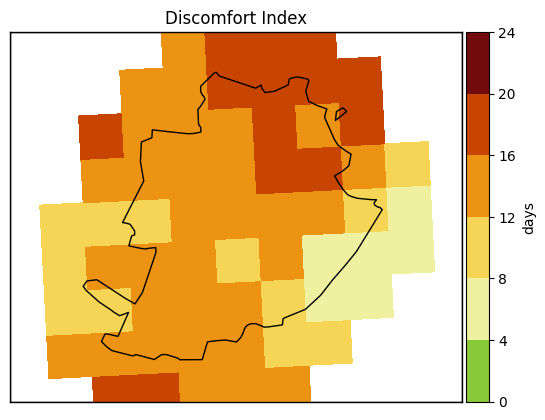

In [31]:
#Map
#ds = xr.open_dataset('/work/remhi/ap21322/SDG/netcdf_indicator/THI_index.nc')

THI = classe_media1
lon = classe_media1.lon.values
lat = classe_media1.lat.values

vmax =  round(np.nanmax(THI),0)
vmin = 0

ticks = np.round(np.arange(vmin, vmax+1,4),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+1,4),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * THI
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax)
cbar.set_label('days')
plt.title('Discomfort Index')
plt.savefig(path_map+'/Di_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Apparent Temperature= It represents the temperature perceived by human beings, resulting from the combined effect of air temperature, relative humidity. 

In [4]:
##DATA
#Loading data: Temperature and Dew point temperature 
data_temp=xr.open_dataset(path+'/T_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
t=data_temp['T_2M']
data_tempdp=xr.open_dataset(path+'/TD_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tdps=data_tempdp['TD_2M']

In [5]:
#Evaluation
temp_deg=t-273.15
temp_deg["units"] = "°C"
tdps_deg=tdps-273.15
tdps_deg.attrs["units"] = "°C"
TApp= -2.653 + 0.994 * temp_deg + 0.0153 * (tdps_deg)**2;  #Tapp = −2.653 + 0.994 × Ta + 0 0153 × Td2

In [6]:
#Evaluation
condition= (TApp>=32) & (TApp<40)  #Threshold indicating conditions of extreme caution
classe=xr.where(condition,1,0)
classe_new=classe.resample(time='1Y').sum(dim='time')
classe_media=classe_new.mean(dim='time')
classe_media1=classe_media.to_dataset(name='TApp')
Apparent_Temperature=classe_media1.to_netcdf(path_nc+'/apparent_temperature_era5-2km-italy_year_comune_torino_1991-2020.nc')

/opt/conda/lib/python3.11/site-packages/xarray/groupers.py:403: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [72]:
#CSV
ds=classe_new.to_dataset(name='TApp[days]')
TApp_mean=ds.mean(dim= ['rlat','rlon']) 
TApp_std=ds.std(dim= ['rlat','rlon'])
df=TApp_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m', 'units'])
df_std=TApp_std.to_dataframe().reset_index().drop(columns=['height_2m','units']).rename(columns= {'TApp[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['TApp[days]'] = np.round(df['TApp[days]'],0)
df.to_csv(path_csv+'/apparent_temperature_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [73]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

TApp_mean= classe_new.mean(dim='time')
clip_var = msk_me * TApp_mean
ds=clip_var.to_dataset(name='TApp[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m', 'units']).dropna().reset_index(drop=True)
df['TApp[d]'] = np.round(df['TApp[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/apparent_temperature_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


/tmp/ipykernel_127/3756750894.py:33: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
/tmp/ipykernel_127/3756750894.py:34: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin = vmin, vmax= vmax)


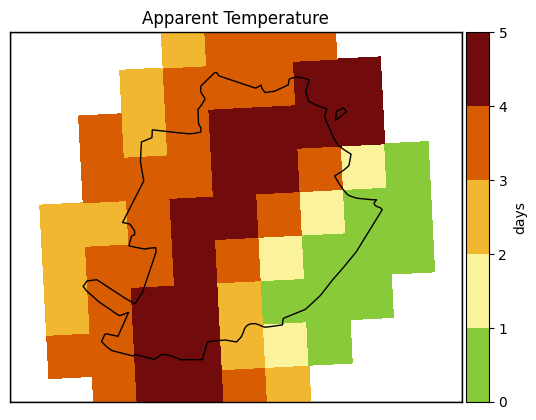

In [74]:
#Map
AT = classe_media 
lon = classe_media.lon.values
lat = classe_media.lat.values

vmax = round(np.nanmax(AT),0)  
vmin = 0

ticks = np.round(np.arange(vmin, vmax+1,1),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+1,1),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * AT
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax)
cbar.set_label('days')
plt.title('Apparent Temperature')
plt.savefig(path_map+'/apparent_temperature_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Warm Days= Number of days with daily maximum temperature greater than the 90th percentile of daily maximum temperature

In [106]:
##DATA
#Loading data: Max. temperature and 90th percentile of Max. temperature
data_temp= xr.open_dataset(path+'/TMAX_2M_1991_2020_VHR-REA_IT_comune_torino.nc') 
tasmax=data_temp['TMAX_2M']
tasmax.attrs["units"] = "°K"
tasmax_per=xr.open_dataset(path_perc+'/90perc_tmax_2m_torino.nc')
tasmax_per=tasmax_per['Tmax_90th']
tasmax_per.attrs["units"] = "°K"

In [107]:
##Evaluation
Warm_days=xc.tx90p(tasmax,tasmax_per, freq='YS', bootstrap=False)
Warm_days_mean=Warm_days.mean(dim='time')
Warm_days_mean=Warm_days_mean.to_dataset(name='Wd')
#Warm_days=Warm_days_mean.to_netcdf(path_nc+'/warm_days_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [108]:
#CSV
ds=Warm_days.to_dataset(name='Tx90p[days]')
tx90p_mean=ds.mean(dim= ['rlat','rlon']) 
tx90p_std=ds.std(dim= ['rlat','rlon'])
df=tx90p_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m', 'quantile'])
df_std=tx90p_std.to_dataframe().reset_index().drop(columns=['height_2m','quantile']).rename(columns= {'Tx90p[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Tx90p[days]'] = np.round(df['Tx90p[days]'],0)
df.to_csv(path_csv+'/warm_days_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [109]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Warm_days_mean=Warm_days.mean(dim='time')
clip_var = msk_me * Warm_days_mean
ds=clip_var.to_dataset(name='Tx90p[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m', 'quantile']).dropna().reset_index(drop=True)
df['Tx90p[d]'] = np.round(df['Tx90p[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/warm_days_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


/tmp/ipykernel_127/3505636391.py:35: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
/tmp/ipykernel_127/3505636391.py:36: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin = vmin, vmax= vmax+1)


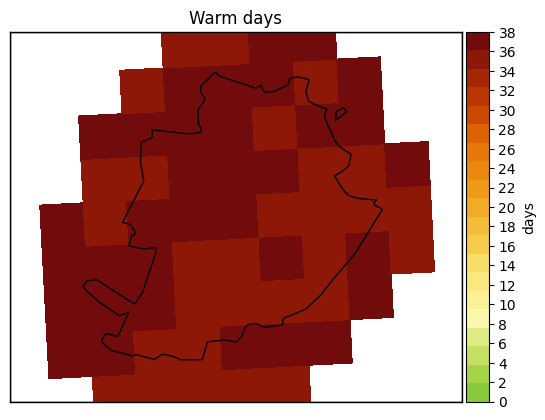

In [89]:
#Map
ds = xr.open_dataset(path_nc+'/warm_days_era5-2km-italy_year_comune_torino_1991-2020.nc')

Wd = np.round((ds['Wd']),0)
lon = ds.lon.values
lat = ds.lat.values

vmax = round(np.nanmax(Wd),0)
vmin = 0

ticks = np.round(np.arange(vmin, vmax+2,2),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+2, 2),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * Wd
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax+1)
cbar.set_label('days')
plt.title('Warm days')
plt.savefig(path_map+'/warm_days_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Warm Wet Days= Number of days with daily mean temperature greater than 75th percentile* of daily mean temperature and with daily precipitation greater than 75th percentile** of daily precipitation

In [90]:
##DATA temp
#Loading data: temperature and 75th percentile of temperature
data_temp = xr.open_dataset(path+'/T_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tas=data_temp['T_2M']
tas.attrs["units"] = "K"
tas_per=percentile_doy(tas, per=75).sel(percentiles=75)
tas_per.attrs["units"] = "K"

In [91]:
##DATA Prec
#Loading data: precipitation and 75th percentile of precipitation
data_prec = xr.open_dataset(path+'/TOT_PREC_1991_2020_VHR-REA_IT_comune_torino.nc')
pr=data_prec['TOT_PREC']
pr.attrs["units"] = "mm/day"
pr_per=percentile_doy(pr, per=75).sel(percentiles=75)
pr_per.attrs["units"] = "mm/day"

In [92]:
#Evaluation for Temp
tas_per = convert_units_to(tas_per, tas)
thresh = resample_doy(tas_per, tas)
tg75 = tas >= thresh
tg75=tg75.values

In [93]:
#Evaluation for Prec
pr_per = convert_units_to(pr_per, pr, context="hydro")
thresh = resample_doy(pr_per, pr)
pr75 = pr >= thresh

In [94]:
#Evaluation
WW= (tg75==True) & (pr75==True)
classe_media1= xr.where(WW,1,0)
classe_media2=classe_media1.resample(time='1Y').sum(dim='time')
classe_media3=classe_media2.mean(dim='time')
classe_media3=classe_media3.to_dataset(name='WW')
#warm_and_wet=classe_media3.to_netcdf(path_nc+'/ww_era5-2km-italy_year_comune_torino_1991-2020.nc')

/opt/conda/lib/python3.11/site-packages/xarray/groupers.py:403: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [95]:
#CSV
ds=classe_media2.to_dataset(name='WW[days]')
Ww_mean=ds.mean(dim= ['rlat','rlon']) 
Ww_std=ds.std(dim= ['rlat','rlon'])
df=Ww_mean.to_dataframe().reset_index().drop(columns=[ 'percentiles'])
df_std=Ww_std.to_dataframe().reset_index().drop(columns=['percentiles']).rename(columns= {'WW[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['WW[days]'] = np.round(df['WW[days]'],0)
df.to_csv(path_csv+'/ww_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [96]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Ww_mean= classe_media2.mean(dim='time')
clip_var = msk_me * Ww_mean
ds=clip_var.to_dataset(name='WW[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'percentiles']).dropna().reset_index(drop=True)
df['WW[d]'] = np.round(df['WW[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/ww_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


/tmp/ipykernel_127/793258905.py:34: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
/tmp/ipykernel_127/793258905.py:35: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin = vmin, vmax= vmax+1)


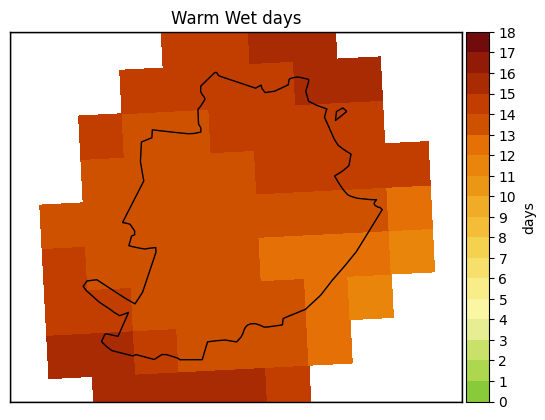

In [97]:
#Map 

WW = classe_media3.WW
lon = classe_media3.lon.values   
lat = classe_media3.lat.values   

vmax = round(np.nanmax(WW),0)  
vmin = 0

ticks = np.round(np.arange(vmin, vmax+2,1),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+2, 1),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * WW
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax+1)
cbar.set_label('days')
plt.title('Warm Wet days')
plt.savefig(path_map+'/ww_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Warm Dry Days= Number of days with daily mean temperature greater than 75th percentile** of daily mean temperature and with daily precipitation less than 25th percentile** of daily precipitation

In [98]:
##DATA Temp
#Loading data: temperature and 75th percentile of temperature
data_temp = xr.open_dataset(path+'/T_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tas=data_temp['T_2M']
tas.attrs["units"] = "K"
tas_per=percentile_doy(tas, per=75).sel(percentiles=75)
tas_per.attrs["units"] = "K"

In [99]:
##DATA Prec
#Loading data: precipitation and 25th percentile of precipitation
data_prec = xr.open_dataset(path+'/TOT_PREC_1991_2020_VHR-REA_IT_comune_torino.nc')
pr=data_prec['TOT_PREC']
pr.attrs["units"] = "mm/day"
pr_per=percentile_doy(pr, per=25).sel(percentiles=25)
pr_per.attrs["units"] = "mm/day"

In [100]:
#Evaluation for Temp
tas_per = convert_units_to(tas_per, tas)
thresh = resample_doy(tas_per, tas)
tg75 = tas >= thresh
#tg75=tg75

In [101]:
#Evaluation for Prec
pr_per = convert_units_to(pr_per, pr, context="hydro")
thresh1 = resample_doy(pr_per, pr)
pr25 = pr <= thresh1
pr25=pr25.values

In [102]:
#Evaluation
WD= (tg75==True) & (pr25==True)
classe_media1= xr.where(WD,1,0)
classe_media2=classe_media1.resample(time='1Y').sum(dim='time')
classe_media3=classe_media2.mean(dim='time')
classe_media3=classe_media3.to_dataset(name='WD')
#warm_and_wet=classe_media3.to_netcdf(path_nc+'/wd_era5-2km-italy_year_comune_torino_1991-2020.nc')

/opt/conda/lib/python3.11/site-packages/xarray/groupers.py:403: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [103]:
#CSV
ds=classe_media2.to_dataset(name='WD[days]')
Wd_mean=ds.mean(dim= ['rlat','rlon']) 
Wd_std=ds.std(dim= ['rlat','rlon'])
df=Wd_mean.to_dataframe().reset_index().drop(columns=[ 'percentiles', 'height_2m'])
df_std=Wd_std.to_dataframe().reset_index().drop(columns=['percentiles']).rename(columns= {'WD[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['WD[days]'] = np.round(df['WD[days]'],0)
df.to_csv(path_csv+'/wd_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [104]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

Wd_mean= classe_media2.mean(dim='time')
clip_var = msk_me * Wd_mean
ds=clip_var.to_dataset(name='WD[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'percentiles', 'height_2m']).dropna().reset_index(drop=True)
df['WD[d]'] = np.round(df['WD[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/wd_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


/tmp/ipykernel_127/40096710.py:35: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
/tmp/ipykernel_127/40096710.py:36: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin = vmin, vmax= vmax+3)


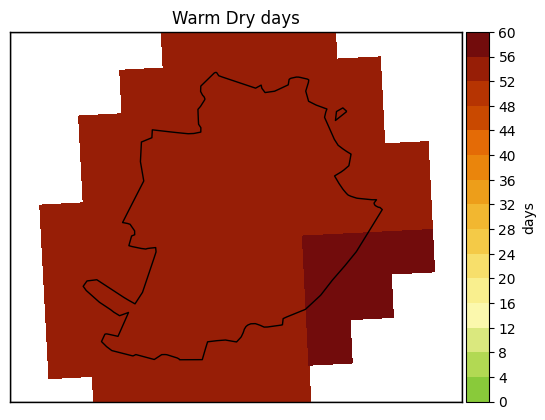

In [105]:
#Map
#ds = xr.open_dataset('/work/remhi/ap21322/SDG/netcdf_indicator/Warm_and_wet.nc')

WD = classe_media3.WD
lon = classe_media3.lon.values   
lat = classe_media3.lat.values   

vmax = round(np.nanmax(WD),0)
vmin = 0

ticks = np.round(np.arange(vmin, vmax+4,4),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+4, 4),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * WD
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax+3)
cbar.set_label('days')
plt.title('Warm Dry days')
plt.savefig(path_map+'/wd_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## Maximum Apparent Temperature 

In [24]:
##DATA
#Loading data: Temperature and Dew point temperature (hourly)
data_temp=xr.open_dataset(path+'/T_2M_1991_2020_VHR-REA_IT_comune_torino_1h.nc')
t=data_temp['T_2M']
data_tempdp=xr.open_dataset(path+'/TD_2M_1991_2020_VHR-REA_IT_comune_torino_1h.nc')
tdps=data_tempdp['TD_2M']

In [ ]:
#Evaluation
temp_deg=t-273.15
temp_deg["units"] = "°C"
tdps_deg=tdps-273.15
tdps_deg.attrs["units"] = "°C"
TAppmax= -2.653 + 0.994 * temp_deg + 0.0153 * (tdps_deg)**2  #Tapp = −2.653 + 0.994 × Ta + 0 0153 × Td2
TAppmax = TAppmax.sortby("time")
TAppmax_daily=TAppmax.resample(time='1D').max(dim='time')

In [ ]:
#Evaluation
condition= (TAppmax_daily>=32) & (TAppmax_daily<40)  #Threshold indicating conditions of extreme caution
classe=xr.where(condition,1,0)
classe_new=classe.resample(time='1Y').sum(dim='time')
classe_media=classe_new.mean(dim='time')

In [121]:
#CSV
ds=classe_new.to_dataset(name='TAppmax[days]')
TApp_mean=ds.mean(dim= ['rlat','rlon']) 
TApp_std=ds.std(dim= ['rlat','rlon'])
df=TApp_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m', 'units'])
df_std=TApp_std.to_dataframe().reset_index().drop(columns=['height_2m','units']).rename(columns= {'TAppmax[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['TAppmax[days]'] = np.round(df['TAppmax[days]'],0)
df.to_csv(path_csv+'/maximum_apparent_temperature_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [ ]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

TApp_mean= classe_new.mean(dim='time')
clip_var = msk_me * TApp_mean
ds=clip_var.to_dataset(name='TAppmax[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m', 'units']).dropna().reset_index(drop=True)
df['TAppmax[d]'] = np.round(df['TAppmax[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
#gdf.to_file(path_shape+'/maximum_apparent_temperature_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

In [ ]:
#Map
AT = classe_media 
lon = classe_media.lon.values
lat = classe_media.lat.values

vmax = round(np.nanmax(AT),0)  
vmin = 0

ticks = np.round(np.arange(vmin, vmax+4,5),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+4,5),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * AT
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax+4)
cbar.set_label('days')
plt.title('Maximum Apparent Temperature')
plt.savefig(path_map+'/maximum_apparent_temperature_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## WS3DI= Total number of days per period in which the daily maximum temperature is greater than the 90th percentile (30 days moving window) of the daily maximum temperature in intervals of at least 3 consecutive days.

In [123]:
##DATA
#Loading data: Max. temperature and 90th percentile of Max. temperature
data_temp= xr.open_dataset(path+'/TMAX_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tasmax=data_temp['TMAX_2M']
tasmax.attrs["units"] = "K"
tasmax_per=xr.open_dataset(path_perc+'/90perc_tmax_2m_torino_30days.nc')
tasmax_per=tasmax_per['Tmax_90th']
tasmax_per.attrs["units"] = "K"

In [125]:
#Evaluation
WS3DI=xc.warm_spell_duration_index(tasmax, tasmax_per, window=3, freq='YS')
WS3DI_mean=WS3DI.mean(dim='time')
WS3DI_mean=WS3DI_mean.to_dataset(name='WS3DI')
#WS3DI=WS3DI_mean.to_netcdf(path_nc+'/ws3di_era5-2km-italy_year_comune_torino_1991-2020.nc')

In [126]:
#CSV
ds=WS3DI.to_dataset(name='Ws3di[days]')
Ws3di_mean=ds.mean(dim= ['rlat','rlon']) #comando per serie storiche
Ws3di_std=ds.std(dim= ['rlat','rlon'])
df=Ws3di_mean.to_dataframe().reset_index().drop(columns=[ 'height_2m', 'quantile']) 
df_std=Ws3di_std.to_dataframe().reset_index().drop(columns=['height_2m','quantile']).rename(columns= {'Ws3di[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Ws3di[days]'] = np.round(df['Ws3di[days]'],0)
df.to_csv(path_csv+'/ws3di_era5-2km-italy_year_comune_torino_1991-2020.csv',index=False)

In [127]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']

WS3DI_mean= WS3DI.mean(dim='time')
clip_var = msk_me * WS3DI_mean
ds=clip_var.to_dataset(name='Ws3di[d]')
df=ds.to_dataframe().reset_index().drop(columns=[ 'rlon', 'rlat', 'height_2m', 'quantile']).dropna().reset_index(drop=True)
df['Ws3di[d]'] = np.round(df['Ws3di[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/ws3di_era5-2km-italy_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


/tmp/ipykernel_127/2197238479.py:35: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
/tmp/ipykernel_127/2197238479.py:36: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin = vmin, vmax= vmax)


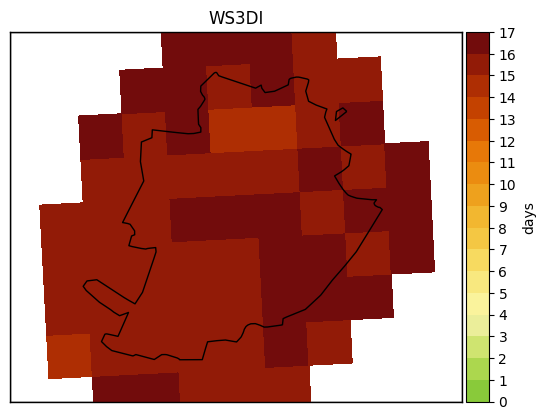

In [128]:
#Map
ds = xr.open_dataset(path_nc+'/ws3di_era5-2km-italy_year_comune_torino_1991-2020.nc')

Ws3di = ds['WS3DI']
lon = ds.lon.values
lat = ds.lat.values

vmax = round(np.nanmax(Ws3di),0) 
vmin = 0

ticks = np.round(np.arange(vmin, vmax+1,1),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+1, 1),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * Ws3di
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()

x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax)
cbar.set_label('days')
plt.title('WS3DI')
plt.savefig(path_map+'/ws3di_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)

## HeatCum

In [129]:
##DATA
#Loading data: Max. temperature and 90th percentile of Max. temperature
data_temp= xr.open_dataset(path+'/TMAX_2M_1991_2020_VHR-REA_IT_comune_torino.nc')
tasmax=data_temp['TMAX_2M']
tasmax.attrs["units"] = "K"
tasmax_per=xr.open_dataset(path_perc+'/90perc_tmax_2m_torino_30days.nc')
tasmax_per=tasmax_per['Tmax_90th']
tasmax_per.attrs["units"] = "K"

In [130]:
##Setting Calendar
finale = xr.DataArray()
temp_fin = tasmax.sel(time=~((tasmax['time.month'] == 2) & (tasmax['time.day'] == 29)))

for i in range(0, len(temp_fin.time.values)): 
    num_giorno = pd.to_datetime(temp_fin[i].time.values).timetuple().tm_yday
    if num_giorno == 366:
        num_giorno = 365
    percentile = tasmax_per.sel(dayofyear = num_giorno)
    
    confronto = xr.where(tasmax[i] > percentile, tasmax[i]-percentile , 0)
    finale = xr.concat([finale, confronto], dim = 'tempo')
    t=finale.dropna(dim="tempo")

In [131]:
##Evaluation
array_coord_maggiore_di_0 = t > 0

#rolling window and consecutive values
consecutive_cells = array_coord_maggiore_di_0.rolling({'tempo': 3}, min_periods = 3).sum()
array_consecutive_maggiore_di_0 = xr.where(consecutive_cells >= 3, t, 0)

#sum
somma = array_consecutive_maggiore_di_0.sum(dim = 'tempo')

/tmp/ipykernel_127/1258399131.py:31: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
/tmp/ipykernel_127/1258399131.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin = vmin, vmax= vmax+12)


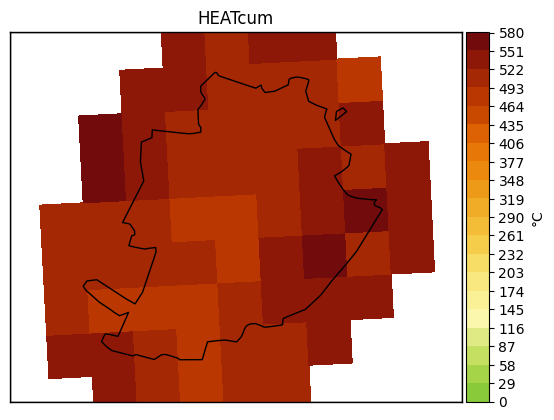

In [132]:
Heatcum= somma
lon = Heatcum.lon.values   
lat = Heatcum.lat.values   

vmax = round(np.nanmax(Heatcum),0)
vmin = 0

ticks = np.round(np.arange(vmin, vmax+12,29),1)
ticks1 = np.append(ticks, vmax)
ticks_label = np.round(np.arange(vmin, vmax+12,29),1)
ticks_label1 = np.append(ticks_label, vmax)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))


cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/Mask_To_new.nc')
msk_me = mask_ds['mask_torino_new']


clip_var = msk_me * Heatcum
mp = Basemap(projection= 'merc', llcrnrlon= np.nanmin(lon) , llcrnrlat= np.nanmin(lat), urcrnrlon= np.nanmax(lon) , urcrnrlat= np.nanmax(lat) , resolution= 'i')
mp.drawmapboundary()
x,y = mp(lon,lat)
mp.drawcoastlines(linewidth = 1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth = 1)

c_scheme = mp.pcolor(x,y,np.squeeze(clip_var[:,:]), cmap= cmap)

cbar= mp.colorbar(c_scheme, location ='right',pad = '1%',ticks = ticks_label)
plt.clim(vmin = vmin, vmax= vmax+12)
cbar.set_label('°C')
plt.title('HEATcum')
plt.savefig(path_map+'/heatcum_era5-2km-italy_year_comune_torino_1991-2020.png', dpi = 300)